# 📊 Machine Learning Project: Sistem Prediksi Penyakit Jantung

**Nama:** Muhammad Alif <br>
**Email Dicoding:** m.alif7890@gmail.com  <br>
**Tanggal:** 23/05/2025

## 1. 🧠 Problem Statement
Penyakit jantung kardiovaskular (Cardiovascular Diseases/CVDs) merupakan penyebab kematian nomor satu secara global, merenggut jutaan nyawa setiap tahunnya. Deteksi dini dan diagnosis yang akurat sangat krusial untuk intervensi medis yang cepat, yang pada gilirannya dapat secara signifikan meningkatkan prognosis pasien dan mengurangi angka kematian.

Dalam menghadapi tantangan ini, teknologi machine learning (ML) menawarkan potensi besar. Algoritma ML mampu menganalisis pola-pola kompleks dalam volume data medis yang besar, mengidentifikasi hubungan tersembunyi antar variabel, dan membuat prediksi dengan tingkat akurasi yang tinggi. Dengan memanfaatkan ML, kita dapat mengembangkan sistem pendukung keputusan yang membantu tenaga medis dalam melakukan skrining awal pada populasi berisiko tinggi dan memprediksi kemungkinan seseorang menderita penyakit jantung, sehingga memungkinkan tindakan pencegahan atau pengobatan yang lebih cepat dan tepat.

Proyek ini bertujuan untuk membangun model machine learning yang dapat memprediksi keberadaan penyakit jantung pada pasien berdasarkan data klinis dan demografis mereka. Ini adalah masalah **Klasifikasi Biner**, di mana model akan memprediksi apakah seorang pasien memiliki penyakit jantung atau tidak.

## 2. 📂 Data Understanding
Dataset yang digunakan dalam proyek ini adalah `heart_disease_uci.csv`, yang merupakan kompilasi dari empat dataset penyakit jantung yang berbeda dari UCI Machine Learning Repository (Cleveland, Hungary, Switzerland, VA Long Beach). Dataset ini diunduh dari Kaggle.

**Sumber Data:** [https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data](https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data)

**Jumlah Sampel & Fitur:**
Awalnya, dataset ini memiliki 1025 sampel (baris) dan 16 kolom (fitur, termasuk ID dan dataset sumber). Setelah pembersihan awal (penghapusan kolom ID dan dataset sumber), dataset akan memiliki 14 fitur yang relevan untuk pemodelan dan 1 variabel target. Dataset ini bersifat kuantitatif (atau dapat dikonversi menjadi kuantitatif) dan memenuhi persyaratan minimal 500 sampel.

**Contoh Kolom Penting:**
*   `age`: Usia pasien.
*   `sex`: Jenis kelamin pasien.
*   `cp`: Tipe nyeri dada.
*   `trestbps`: Tekanan darah saat istirahat.
*   `chol`: Kolesterol serum.
*   `thalch`: Detak jantung maksimum yang dicapai.
*   `target` (setelah transformasi): Variabel target, menunjukkan adanya penyakit jantung (1) atau tidak (0).

**Tujuan dari Data Ini:**
Data ini bertujuan untuk menyediakan informasi medis dan demografis pasien yang dapat digunakan untuk melatih model machine learning. Model ini diharapkan dapat belajar dari pola-pola dalam data ini untuk memprediksi risiko penyakit jantung pada individu baru.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/miezlearning/Coding-Camp-2025/refs/heads/master/Machine%20Learning%20Terapan/Dataset/heart_disease_uci.csv')

print("5 Baris Pertama Dataset:")
print(df.head())

print("\nInformasi Umum Dataset:")
df.info()

print("\nStatistik Deskriptif Dataset:")
print(df.describe())

5 Baris Pertama Dataset:
   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4          

## 3. 🧹 Data Preparation
Tahap Data Preparation sangat penting untuk memastikan data dalam format yang benar dan berkualitas tinggi untuk proses pemodelan. Ini meliputi penanganan nilai yang hilang, konversi tipe data, encoding variabel kategorikal, dan feature scaling. Untuk menjaga alur logis, *initial data cleaning* dilakukan di awal bagian ini, sementara *advanced preprocessing* (menggunakan pipeline) akan didefinisikan setelah EDA dan diterapkan sebelum modeling.

### 3.1 Initial Data Cleaning dan Transformasi Target
Observasi awal menunjukkan beberapa masalah data yang perlu ditangani:
1.  Nilai `'?'` dan spasi kosong (`' '`) yang merepresentasikan missing values di beberapa kolom.
2.  Kolom `'sex'`, `'fbs'`, `'exang'` menggunakan string (`'Male'/'Female'`, `'TRUE'/'FALSE'`) yang perlu dikonversi ke numerik (0/1).
3.  Kolom numerik seperti `'trestbps'`, `'chol'`, `'thalch'` memiliki nilai `0` yang, dalam konteks medis, seringkali menandakan nilai yang hilang (karena kolesterol atau tekanan darah tidak mungkin 0 pada pasien hidup).
4.  Kolom `'id'` dan `'dataset'` tidak relevan untuk pemodelan dan akan dihapus.
5.  Kolom `'num'` adalah target kita, tetapi memiliki nilai 0, 1, 2, 3, 4. Kita akan mengubahnya menjadi binary (0 = tidak ada penyakit, 1 = ada penyakit).


In [3]:
# Mengganti '?' dan spasi kosong dengan NaN
df.replace(['?', ' ', ''], np.nan, inplace=True)

# Mengkonversi kolom 'sex', 'fbs', 'exang' ke numerik (0/1)
df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})
df['fbs'] = df['fbs'].map({'TRUE': 1, 'FALSE': 0})
df['exang'] = df['exang'].map({'TRUE': 1, 'FALSE': 0})

# Mengkonversi kolom 'ca' dan 'num' ke tipe numerik (mereka mungkin menjadi objek setelah replace NaN)
df['ca'] = pd.to_numeric(df['ca'])
df['num'] = pd.to_numeric(df['num'])

# Mengidentifikasi dan Mengganti nilai 0 yang tidak valid pada fitur numerik kunci dengan NaN
# Tekanan darah, kolesterol, dan detak jantung maksimum tidak mungkin 0 pada orang hidup.
cols_with_invalid_zero = ['trestbps', 'chol', 'thalch']
for col in cols_with_invalid_zero:
    df[col] = df[col].replace(0, np.nan)

# Drop kolom 'id' dan 'dataset' karena tidak relevan sebagai fitur
df.drop(['id', 'dataset'], axis=1, inplace=True)

# Menentukan variabel target (binary: 0 = no disease, 1 = disease)
# Kolom 'num' dari dataset aslinya berkisar 0-4, di mana 0 berarti tidak ada penyakit,
# dan 1-4 berarti adanya berbagai tingkat penyakit jantung.
# Untuk tujuan klasifikasi biner, kita akan menganggap 0 sebagai 'tidak ada penyakit' (0)
# dan 1-4 sebagai 'ada penyakit' (1).
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
df.drop('num', axis=1, inplace=True) # Hapus kolom 'num' asli

# Tampilkan kembali informasi umum dataset setelah pembersihan awal
print("Informasi Dataset Setelah Pembersihan Awal:")
df.info()

# Cek kembali missing values setelah pembersihan awal
print("\nJumlah Missing Values Setelah Pembersihan Awal:")
print(df.isnull().sum())
print("\nPersentase Missing Values Setelah Pembersihan Awal:")
print(df.isnull().sum() / len(df) * 100)

Informasi Dataset Setelah Pembersihan Awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    int64  
 2   cp        920 non-null    object 
 3   trestbps  860 non-null    float64
 4   chol      718 non-null    float64
 5   fbs       0 non-null      float64
 6   restecg   918 non-null    object 
 7   thalch    865 non-null    float64
 8   exang     0 non-null      float64
 9   oldpeak   858 non-null    float64
 10  slope     611 non-null    object 
 11  ca        309 non-null    float64
 12  thal      434 non-null    object 
 13  target    920 non-null    int64  
dtypes: float64(7), int64(3), object(4)
memory usage: 100.8+ KB

Jumlah Missing Values Setelah Pembersihan Awal:
age           0
sex           0
cp            0
trestbps     60
chol        202
fbs         920
restecg       2
th

## 4. 📊 Exploratory Data Analysis (EDA)
Pada tahap ini, kita akan melakukan analisis mendalam untuk memahami distribusi data, korelasi antar fitur, dan hubungan fitur dengan variabel target. Visualisasi akan digunakan untuk mendapatkan insight yang lebih baik mengenai karakteristik data.

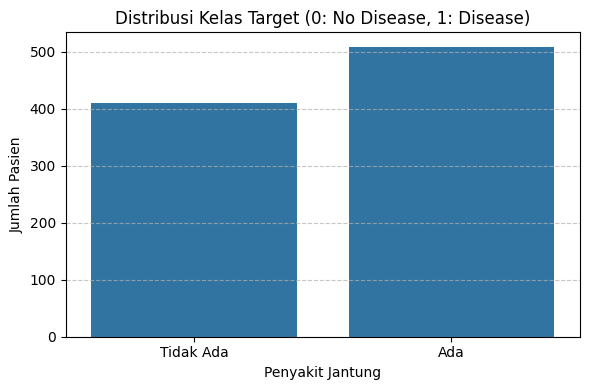


Distribusi Nilai Variabel Target:
target
1    509
0    411
Name: count, dtype: int64
Persentase Kelas 'Tidak Ada Penyakit': 44.67%
Persentase Kelas 'Ada Penyakit': 55.33%

Fitur Numerik: ['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalch', 'exang', 'oldpeak', 'ca']
Fitur Kategorikal: ['cp', 'restecg', 'slope', 'thal']


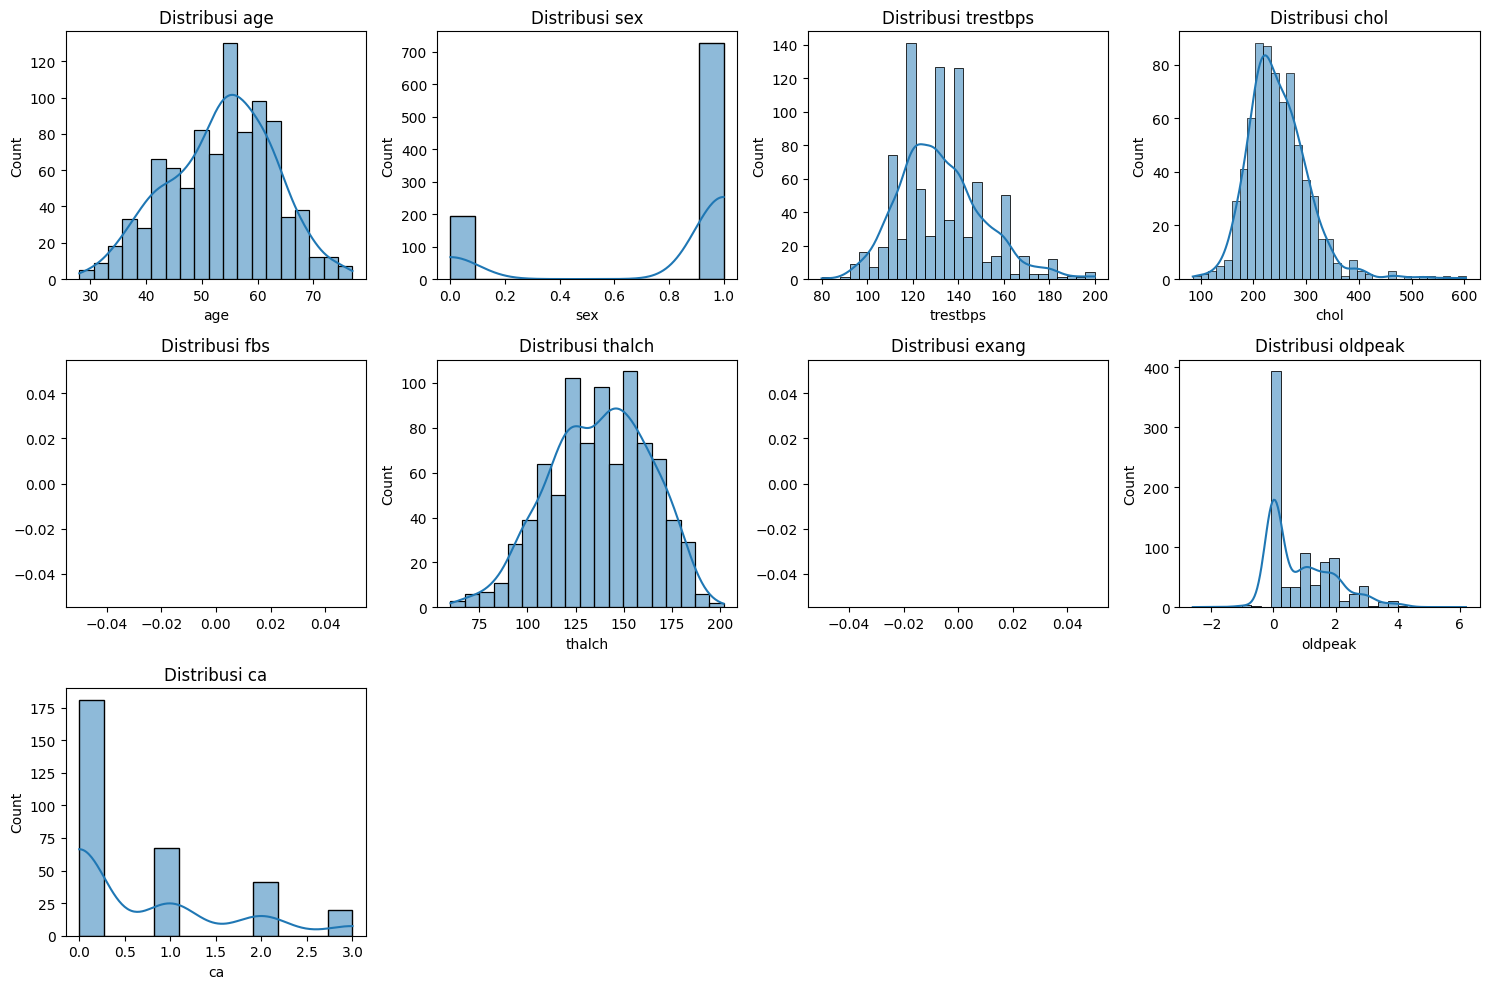

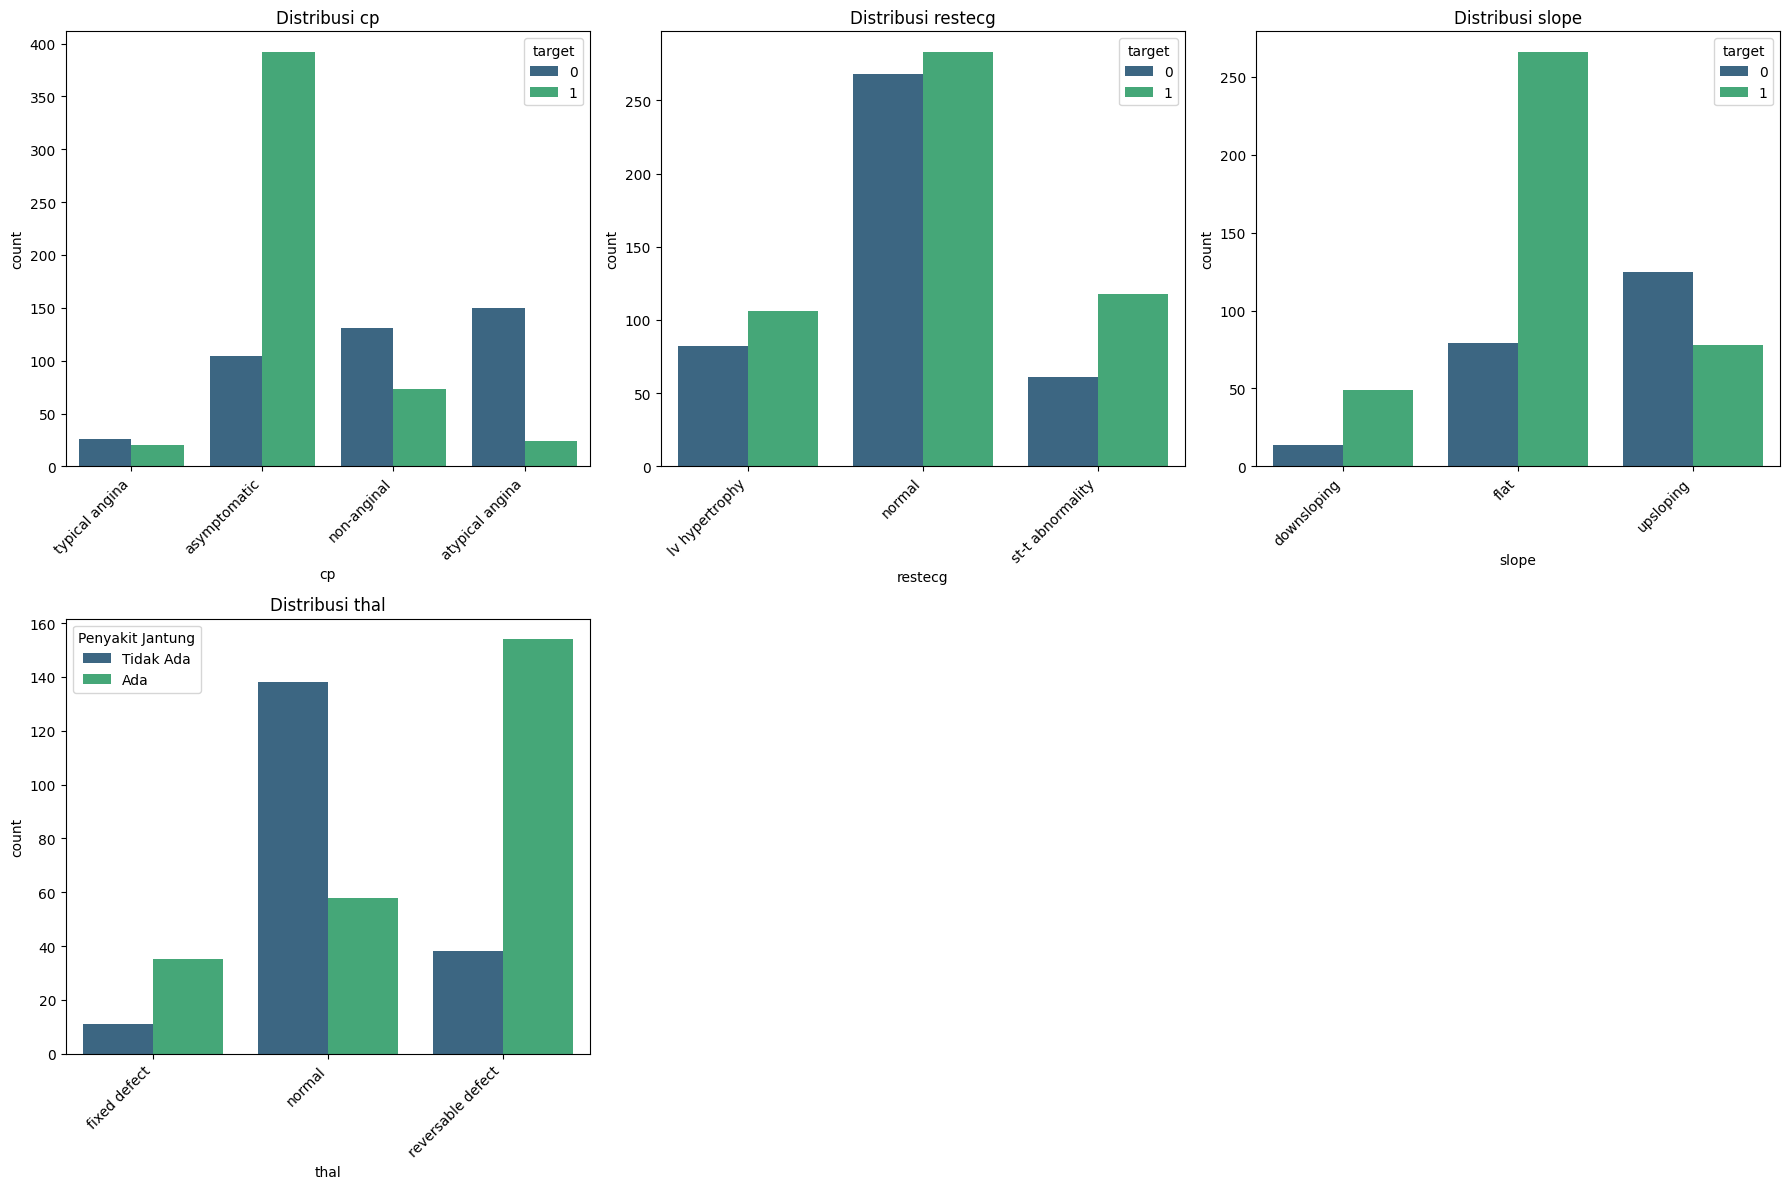

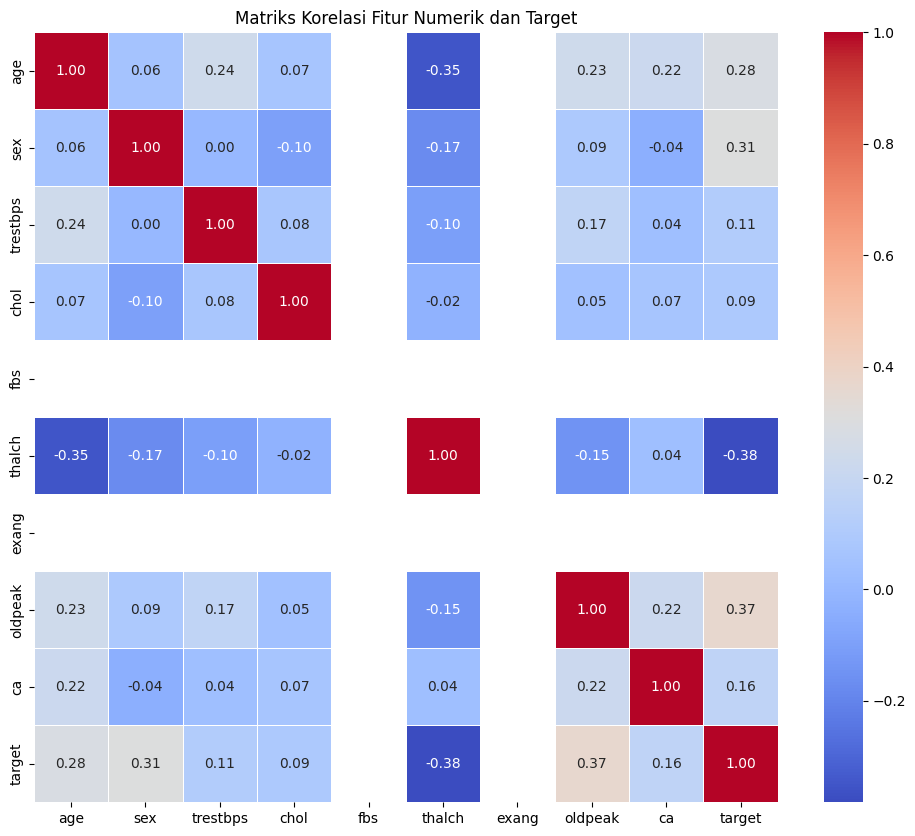

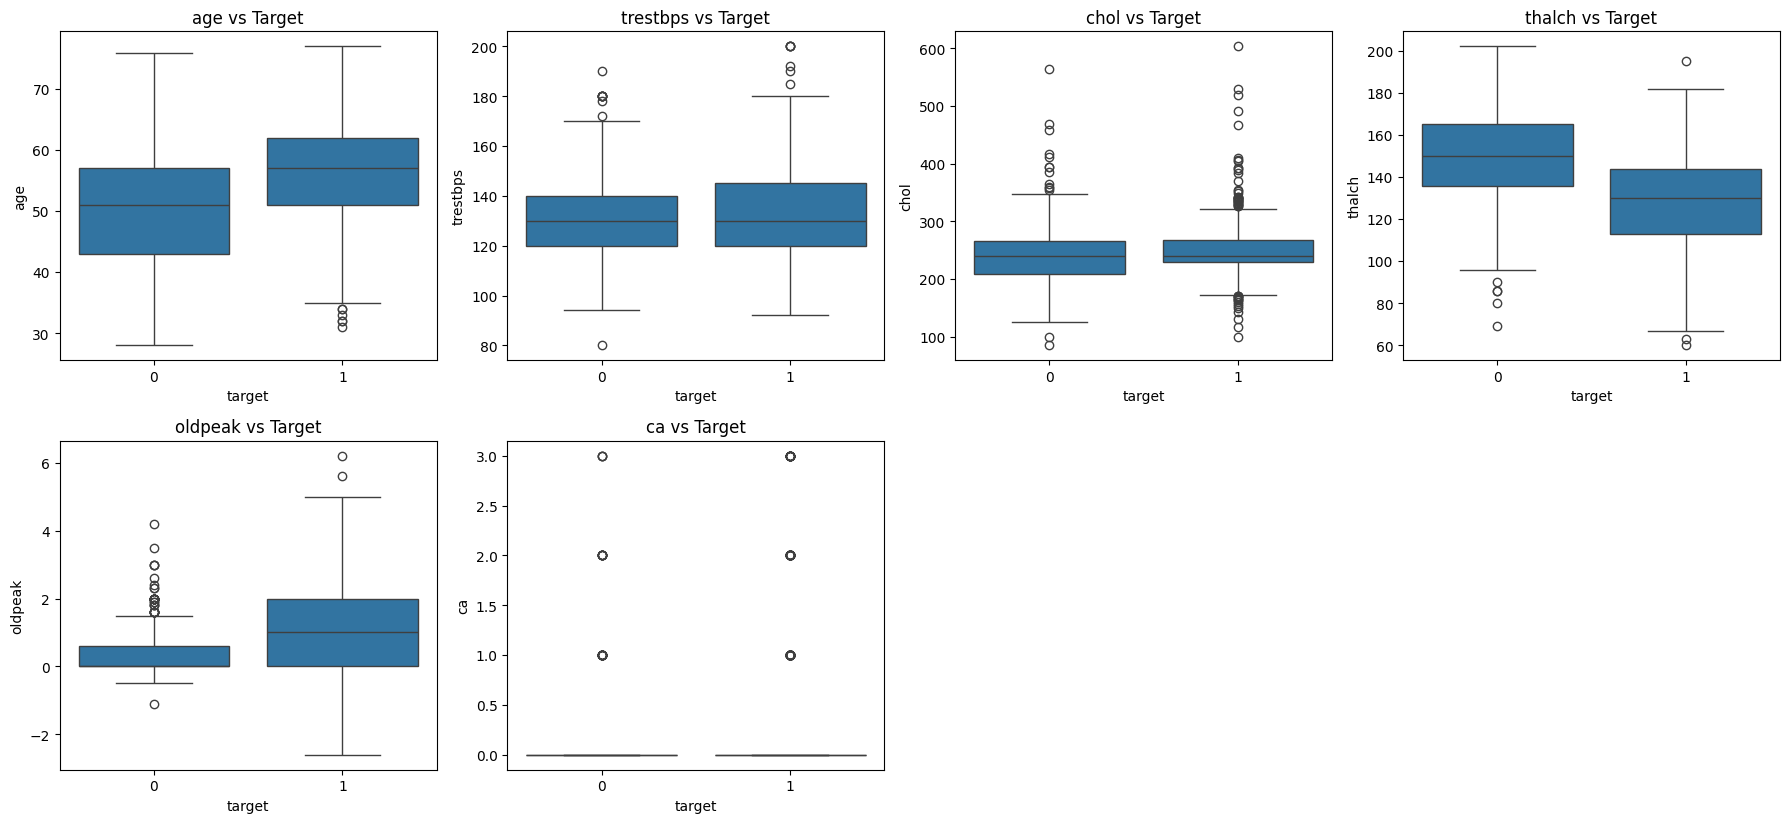

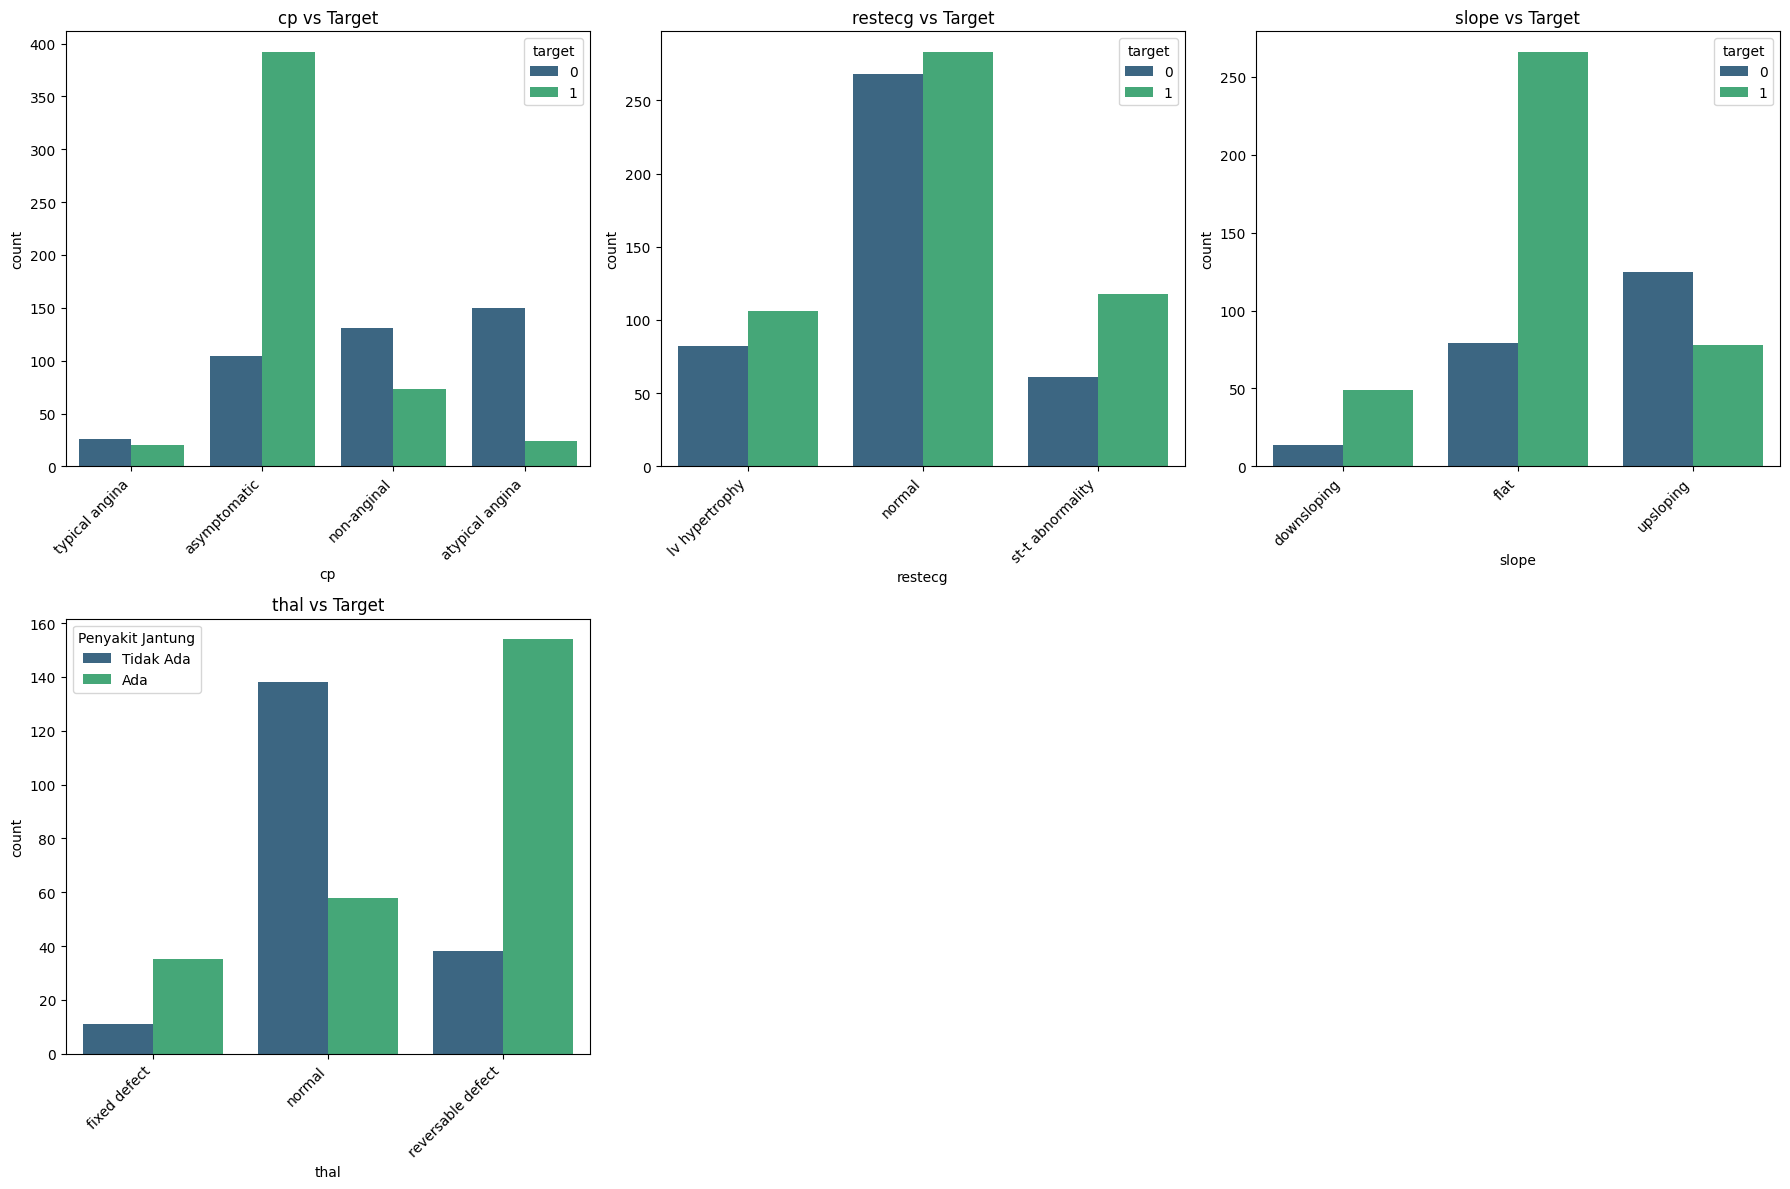

In [8]:
# Distribusi Variabel Target
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('Distribusi Kelas Target (0: No Disease, 1: Disease)')
plt.xlabel('Penyakit Jantung')
plt.ylabel('Jumlah Pasien')
plt.xticks(ticks=[0, 1], labels=['Tidak Ada', 'Ada'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nDistribusi Nilai Variabel Target:")
print(df['target'].value_counts())
print(f"Persentase Kelas 'Tidak Ada Penyakit': {df['target'].value_counts(normalize=True)[0]*100:.2f}%")
print(f"Persentase Kelas 'Ada Penyakit': {df['target'].value_counts(normalize=True)[1]*100:.2f}%")
# Observasi: Ada ketidakseimbangan kelas, meskipun tidak terlalu parah. Ini perlu dipertimbangkan
# dalam pemilihan metrik evaluasi (F1-score, Recall, ROC AUC lebih baik daripada akurasi).

# Memisahkan Fitur Numerik dan Kategorikal untuk EDA
# Re-identify numeric and categorical features after initial cleaning
numeric_features = df.select_dtypes(include=np.number).columns.tolist()
categorical_features = df.select_dtypes(include='object').columns.tolist()
continuous_numeric_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

# Hilangkan 'target' dari numeric_features untuk visualisasi distribusi fitur
if 'target' in numeric_features:
    numeric_features.remove('target')

print("\nFitur Numerik:", numeric_features) # This list still includes binary/categorical-like numerics
print("Fitur Kategorikal:", categorical_features)

# Distribusi Fitur Numerik
plt.figure(figsize=(15, 10))
# Use the full numeric_features list for overall distribution, including binary ones
for i, feature in enumerate(numeric_features):
    plt.subplot(3, 4, i + 1)
    # Ensure the column is treated numerically for the plot
    sns.histplot(pd.to_numeric(df[feature], errors='coerce').dropna(), kde=True) # dropna karena masih ada NaN
    plt.title(f'Distribusi {feature}')
plt.tight_layout()
plt.show()
# Observasi: Beberapa fitur seperti 'age', 'thalch' terlihat normal. 'oldpeak' cenderung zero-inflated.
# Beberapa fitur lainnya menunjukkan skewness atau distribusi yang unik.

# Distribusi Fitur Kategorikal (sebelum One-Hot Encoding)
plt.figure(figsize=(18, 12))
for i, feature in enumerate(categorical_features):
    plt.subplot(2, 3, i + 1)
    # Use the original df for categorical plots, as we handle NaNs later in the pipeline
    # Or handle NaNs in categorical columns here specifically for plotting if needed,
    # but countplot handles them by default.
    sns.countplot(x=feature, hue='target', data=df, palette='viridis')
    plt.title(f'Distribusi {feature}')
    plt.xticks(rotation=45, ha='right')
plt.legend(title='Penyakit Jantung', labels=['Tidak Ada', 'Ada'])
plt.tight_layout()
plt.show()
# Observasi:
# - 'cp': 'asymptomatic' adalah tipe nyeri dada yang paling umum.
# - 'restecg': 'normal' adalah yang paling umum.
# - 'slope': 'upsloping' adalah yang paling umum.
# - 'thal': 'normal' dan 'reversable defect' mendominasi. Ada beberapa NaN.

# Korelasi Antar Fitur (hanya untuk fitur numerik yang sudah bersih/sebagian)
# Imputasi sementara untuk korelasi dan boxplot agar tidak ada NaN yang mengganggu perhitungan
df_corr = df.copy()
# Kolom yang akan digunakan untuk korelasi dan boxplots, after handling '0' as NaN and ensuring numeric type
# Convert all numeric columns to numeric type, coercing errors to NaN
for col in df_corr.select_dtypes(include=np.number).columns:
     df_corr[col] = pd.to_numeric(df_corr[col], errors='coerce')

# Include all numerical features for correlation matrix calculation, including binary ones
all_numeric_cols_for_eda = df_corr.select_dtypes(include=np.number).columns.tolist()

# Impute NaNs in the copied dataframe for correlation calculation
for col in all_numeric_cols_for_eda:
    if df_corr[col].isnull().any():
        df_corr[col].fillna(df_corr[col].median(), inplace=True) # Using median for robustness

# Hitung matriks korelasi
# Use the imputed dataframe for correlation
correlation_matrix = df_corr[all_numeric_cols_for_eda].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriks Korelasi Fitur Numerik dan Target')
plt.show()
# Observasi:
# - Beberapa fitur memiliki korelasi yang cukup signifikan dengan 'target' (misalnya, 'oldpeak', 'exang', 'thalch').
# - Ada juga korelasi antar fitur (misalnya, 'age' dan 'chol').

# Hubungan Fitur dengan Target (Numerik vs. Target)
plt.figure(figsize=(18, 12))
# Iterate through the *explicitly continuous/quantitative* numeric features for boxplots
for i, feature in enumerate(continuous_numeric_features):
    plt.subplot(3, 4, i + 1)
    # Use the imputed dataframe df_corr for plotting
    # Ensure the feature is numeric for plotting
    sns.boxplot(x='target', y=pd.to_numeric(df_corr[feature], errors='coerce'), data=df_corr)
    plt.title(f'{feature} vs Target')
plt.tight_layout()
plt.show()
# Observasi:
# - 'age': Rentang usia pasien dengan penyakit jantung (target=1) tampak lebih tinggi.
# - 'thalch': Detak jantung maksimum cenderung lebih rendah pada pasien dengan penyakit jantung.
# - 'oldpeak': Nilai 'oldpeak' lebih tinggi pada pasien dengan penyakit jantung.
# - 'exang': Pasien dengan angina akibat olahraga ('exang'=1) lebih sering memiliki penyakit jantung.
# - 'sex': Proporsi pria (sex=1) yang memiliki penyakit jantung lebih tinggi.

# Hubungan Fitur dengan Target (Kategorikal vs. Target)
plt.figure(figsize=(18, 12))
for i, feature in enumerate(categorical_features):
    plt.subplot(2, 3, i + 1)
    # Use the original df for categorical plots, as we handle NaNs later in the pipeline
    # Or handle NaNs in categorical columns here specifically for plotting if needed,
    # but countplot handles them by default.
    sns.countplot(x=feature, hue='target', data=df, palette='viridis')
    plt.title(f'{feature} vs Target')
    plt.xticks(rotation=45, ha='right')
plt.legend(title='Penyakit Jantung', labels=['Tidak Ada', 'Ada'])
plt.tight_layout()
plt.show()
# Observasi:
# - 'cp': Tipe nyeri dada 'asymptomatic' ('typical angina' juga) sangat berkorelasi dengan penyakit jantung.
# - 'restecg': Pasien dengan 'lv hypertrophy' atau 'st-t abnormality' cenderung memiliki penyakit jantung.
# - 'slope': 'flat' atau 'downsloping' lebih sering terkait dengan penyakit jantung.
# - 'thal': 'reversable defect' adalah indikator kuat penyakit jantung.

## 5. 🏗️ Modeling
Pada tahap ini, kita akan membangun beberapa model machine learning untuk memprediksi penyakit jantung. Kita akan mengevaluasi Logistic Regression sebagai baseline, Random Forest sebagai model ensemble yang kuat, dan LightGBM sebagai model boosting yang efisien dan berkinerja tinggi. Proses hyperparameter tuning akan dilakukan untuk setiap model menggunakan GridSearchCV untuk menemukan konfigurasi terbaik.

### 5.1. Pemisahan Data dan Pipeline Preprocessing Lanjutan
Sebelum modeling, kita akan memisahkan data menjadi training dan testing set. Setelah itu, pipeline preprocessing yang telah didefinisikan sebelumnya akan diterapkan. Pipeline ini akan melakukan imputasi missing values, encoding variabel kategorikal, dan feature scaling secara otomatis dan konsisten pada data latih dan uji.


In [10]:
# Memisahkan Fitur (X) dan Target (y)
X = df.drop('target', axis=1)
y = df['target']

# Memisahkan data training dan testing
# Menggunakan stratify=y untuk memastikan proporsi kelas target yang sama di train dan test set
# Random state digunakan untuk replikasi hasil
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Ukuran X_train: {X_train.shape}")
print(f"Ukuran X_test: {X_test.shape}")
print(f"Ukuran y_train: {y_train.shape}")
print(f"Ukuran y_test: {y_test.shape}")

# Mengidentifikasi kolom numerik dan kategorikal untuk pipeline
numerical_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

# Pipeline untuk fitur numerik: Imputasi median lalu Scaling
# Alasan median: Lebih robust terhadap outlier dibandingkan mean.
# Alasan StandardScaler: Cocok untuk model yang sensitif terhadap skala (seperti Logistic Regression).
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Mengisi NaN dengan median
    ('scaler', StandardScaler())                    # Menskalakan fitur
])

# Pipeline untuk fitur kategorikal: Imputasi modus lalu One-Hot Encoding
# Alasan modus: Mengisi NaN dengan nilai yang paling sering muncul untuk data kategorikal.
# Alasan OneHotEncoder: Mencegah model mengasumsikan urutan atau hubungan ordinal pada fitur nominal.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # Mengkonversi ke one-hot encoding
])

# Menggabungkan semua preprocessing menggunakan ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough' # Biarkan kolom lain yang tidak disebut apa adanya (jika ada)
)

### 5.2. Pemilihan dan Tuning Model
# Mendefinisikan model-model yang akan diuji
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1) # verbose=-1 untuk menonaktifkan output peringatan
}

# Mendefinisikan hyperparameter grid untuk tuning
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 1, 10, 100], # Inverse of regularization strength
        'classifier__solver': ['liblinear', 'lbfgs']
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200, 300], # Number of trees in the forest
        'classifier__max_depth': [None, 10, 20],     # Maximum depth of the tree
        'classifier__min_samples_split': [2, 5, 10]  # Minimum number of samples required to split an internal node
    },
    'LightGBM': {
        'classifier__n_estimators': [100, 200, 300], # Number of boosting rounds
        'classifier__learning_rate': [0.01, 0.05, 0.1], # Shrinks the contribution of each tree
        'classifier__num_leaves': [20, 31, 40]       # Max number of leaves in one tree
    }
}

# Kamus untuk menyimpan hasil model terbaik
best_models = {}
model_performance = []

# Proses pelatihan dan tuning model
print("Memulai proses pemodelan dan hyperparameter tuning...\n")
for model_name, model in models.items():
    print(f"Melatih dan melakukan tuning untuk {model_name}...")

    # Membuat pipeline lengkap (preprocessing + classifier)
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Menggunakan GridSearchCV untuk hyperparameter tuning dengan cross-validation
    # Alasan memilih 'f1' sebagai metrik scoring untuk tuning:
    # F1-score adalah rata-rata harmonik dari Precision dan Recall. Ini adalah metrik yang baik
    # untuk mengukur kinerja model klasifikasi ketika ada ketidakseimbangan kelas,
    # karena ia memberikan bobot yang sama pada False Positives dan False Negatives,
    # yang penting dalam konteks medis (kita ingin meminimalkan keduanya:
    # tidak salah mendiagnosis sehat padahal sakit, dan tidak salah mendiagnosis sakit padahal sehat).
    grid_search = GridSearchCV(full_pipeline,
                               param_grid=param_grids[model_name],
                               cv=5, # 5-Fold Cross-Validation untuk estimasi performa yang robust
                               scoring='f1',
                               n_jobs=-1, # Menggunakan semua core CPU yang tersedia
                               verbose=1)

    grid_search.fit(X_train, y_train)

    best_models[model_name] = grid_search.best_estimator_
    print(f"Model terbaik untuk {model_name}: {grid_search.best_params_}")
    print(f"Skor F1 rata-rata cross-validation terbaik: {grid_search.best_score_:.4f}\n")

print("Proses pemodelan selesai.")
# Memisahkan Fitur (X) dan Target (y)
X = df.drop('target', axis=1)
y = df['target']

# Memisahkan data training dan testing
# Menggunakan stratify=y untuk memastikan proporsi kelas target yang sama di train dan test set
# Random state digunakan untuk replikasi hasil
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Ukuran X_train: {X_train.shape}")
print(f"Ukuran X_test: {X_test.shape}")
print(f"Ukuran y_train: {y_train.shape}")
print(f"Ukuran y_test: {y_test.shape}")

# Mengidentifikasi kolom numerik dan kategorikal untuk pipeline
numerical_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

# Pipeline untuk fitur numerik: Imputasi median lalu Scaling
# Alasan median: Lebih robust terhadap outlier dibandingkan mean.
# Alasan StandardScaler: Cocok untuk model yang sensitif terhadap skala (seperti Logistic Regression).
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Mengisi NaN dengan median
    ('scaler', StandardScaler())                    # Menskalakan fitur
])

# Pipeline untuk fitur kategorikal: Imputasi modus lalu One-Hot Encoding
# Alasan modus: Mengisi NaN dengan nilai yang paling sering muncul untuk data kategorikal.
# Alasan OneHotEncoder: Mencegah model mengasumsikan urutan atau hubungan ordinal pada fitur nominal.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # Mengkonversi ke one-hot encoding
])

# Menggabungkan semua preprocessing menggunakan ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough' # Biarkan kolom lain yang tidak disebut apa adanya (jika ada)
)

### 5.2. Pemilihan dan Tuning Model
# Mendefinisikan model-model yang akan diuji
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1) # verbose=-1 untuk menonaktifkan output peringatan
}

# Mendefinisikan hyperparameter grid untuk tuning
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 1, 10, 100], # Inverse of regularization strength
        'classifier__solver': ['liblinear', 'lbfgs']
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200, 300], # Number of trees in the forest
        'classifier__max_depth': [None, 10, 20],     # Maximum depth of the tree
        'classifier__min_samples_split': [2, 5, 10]  # Minimum number of samples required to split an internal node
    },
    'LightGBM': {
        'classifier__n_estimators': [100, 200, 300], # Number of boosting rounds
        'classifier__learning_rate': [0.01, 0.05, 0.1], # Shrinks the contribution of each tree
        'classifier__num_leaves': [20, 31, 40]       # Max number of leaves in one tree
    }
}

# Kamus untuk menyimpan hasil model terbaik
best_models = {}
model_performance = []

# Proses pelatihan dan tuning model
print("Memulai proses pemodelan dan hyperparameter tuning...\n")
for model_name, model in models.items():
    print(f"Melatih dan melakukan tuning untuk {model_name}...")

    # Membuat pipeline lengkap (preprocessing + classifier)
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Menggunakan GridSearchCV untuk hyperparameter tuning dengan cross-validation
    # Alasan memilih 'f1' sebagai metrik scoring untuk tuning:
    # F1-score adalah rata-rata harmonik dari Precision dan Recall. Ini adalah metrik yang baik
    # untuk mengukur kinerja model klasifikasi ketika ada ketidakseimbangan kelas,
    # karena ia memberikan bobot yang sama pada False Positives dan False Negatives,
    # yang penting dalam konteks medis (kita ingin meminimalkan keduanya:
    # tidak salah mendiagnosis sehat padahal sakit, dan tidak salah mendiagnosis sakit padahal sehat).
    grid_search = GridSearchCV(full_pipeline,
                               param_grid=param_grids[model_name],
                               cv=5, # 5-Fold Cross-Validation untuk estimasi performa yang robust
                               scoring='f1',
                               n_jobs=-1, # Menggunakan semua core CPU yang tersedia
                               verbose=1)

    grid_search.fit(X_train, y_train)

    best_models[model_name] = grid_search.best_estimator_
    print(f"Model terbaik untuk {model_name}: {grid_search.best_params_}")
    print(f"Skor F1 rata-rata cross-validation terbaik: {grid_search.best_score_:.4f}\n")

print("Proses pemodelan selesai.")

### 5.3. Pemilihan Model Terbaik dan Analisis Feature Importance
# Setelah melatih dan melakukan tuning untuk beberapa model, kita akan memilih model terbaik berdasarkan performa pada data uji (X_test, y_test). Metrik F1-score, Recall, dan ROC AUC akan menjadi pertimbangan utama, mengingat pentingnya meminimalkan false negatives dalam prediksi penyakit jantung.

Ukuran X_train: (736, 13)
Ukuran X_test: (184, 13)
Ukuran y_train: (736,)
Ukuran y_test: (184,)
Memulai proses pemodelan dan hyperparameter tuning...

Melatih dan melakukan tuning untuk Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Model terbaik untuk Logistic Regression: {'classifier__C': 0.1, 'classifier__solver': 'liblinear'}
Skor F1 rata-rata cross-validation terbaik: 0.8319

Melatih dan melakukan tuning untuk Random Forest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Model terbaik untuk Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Skor F1 rata-rata cross-validation terbaik: 0.8323

Melatih dan melakukan tuning untuk LightGBM...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Model terbaik untuk LightGBM: {'classifier__learning_rate': 0.05, 'classifier__n_estimators': 200, 'classifier__num_leaves': 31}
Skor F1 rata-rata cross-validation ter

## 6. 📈 Evaluation
Tahap evaluasi adalah untuk menilai kinerja model terbaik pada data yang belum pernah dilihat sebelumnya (data uji). Kita akan menggunakan beberapa metrik evaluasi yang relevan untuk masalah klasifikasi, menjelaskan apa arti setiap metrik, dan bagaimana model kita bekerja berdasarkan metrik tersebut.

### Performa Model Terbaik pada Data Uji
Kita akan membandingkan performa model-model yang telah di-tuning pada data uji untuk memilih yang terbaik.


Performa Model Terbaik pada Data Uji:

                     Accuracy  Precision  Recall  F1-Score  ROC AUC
Model                                                              
Logistic Regression    0.7880     0.7788  0.8627    0.8186   0.8928
Random Forest          0.8152     0.7881  0.9118    0.8455   0.9002
LightGBM               0.8424     0.8349  0.8922    0.8626   0.8782
Logistic Regression    0.7880     0.7788  0.8627    0.8186   0.8928
Random Forest          0.8152     0.7881  0.9118    0.8455   0.9002
LightGBM               0.8424     0.8349  0.8922    0.8626   0.8782
Logistic Regression    0.7880     0.7788  0.8627    0.8186   0.8928
Random Forest          0.8152     0.7881  0.9118    0.8455   0.9002
LightGBM               0.8424     0.8349  0.8922    0.8626   0.8782
Logistic Regression    0.7880     0.7788  0.8627    0.8186   0.8928
Random Forest          0.8152     0.7881  0.9118    0.8455   0.9002
LightGBM               0.8424     0.8349  0.8922    0.8626   0.8782

Model te

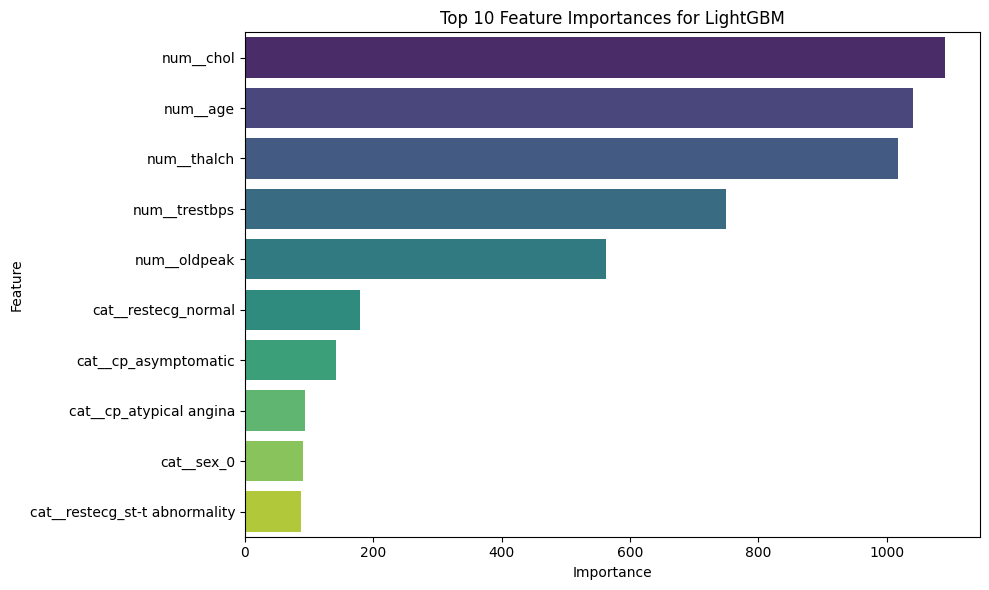


--- Ringkasan Hasil Evaluasi Model Terbaik ---
Model Terpilih: LightGBM
Accuracy: 0.8424
Precision: 0.8349
Recall: 0.8922
F1-Score: 0.8626
ROC AUC: 0.8782

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.78      0.82        82
           1       0.83      0.89      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



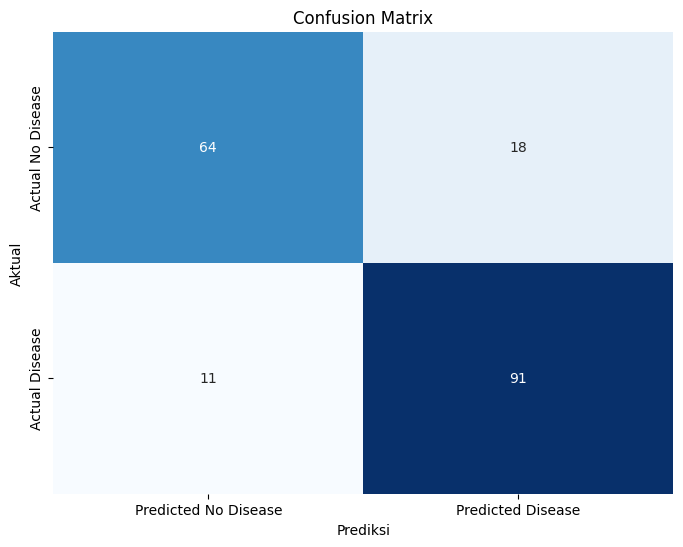

<Figure size 800x600 with 0 Axes>

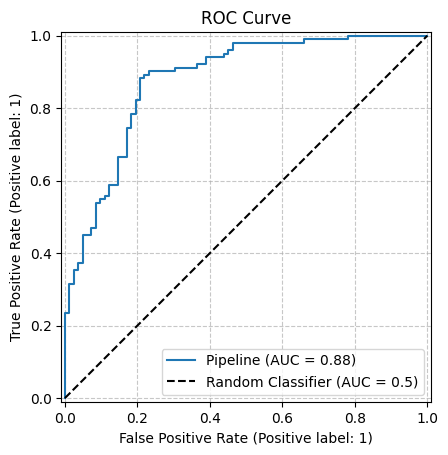

In [14]:
# Evaluasi semua model terbaik pada data uji
results = {}
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] # Probabilitas kelas positif

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc
    }
    model_performance.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc
    })

results_df = pd.DataFrame(model_performance).set_index('Model')
print("Performa Model Terbaik pada Data Uji:\n")
print(results_df.round(4))

# Memilih model terbaik berdasarkan F1-Score atau ROC AUC
best_model_name = results_df['F1-Score'].idxmax() # Atau 'ROC AUC'. F1-Score lebih seimbang.
chosen_best_model = best_models[best_model_name]

print(f"\nModel terbaik yang dipilih adalah: {best_model_name}")
# Access the single value using index [0] instead of .item()
print(f"Dengan F1-Score: {results_df.loc[best_model_name, 'F1-Score'][0]:.4f}")

### Analisis Feature Importance untuk Model Terbaik (Random Forest/LightGBM)
# Ini adalah Rubrik Tambahan yang bagus untuk interpretasi model.
if best_model_name in ['Random Forest', 'LightGBM']:
    print(f"\nAnalisis Feature Importance untuk {best_model_name}:\n")

    # Ambil preprocessor yang sudah dilatih dari model terbaik
    fitted_preprocessor = chosen_best_model.named_steps['preprocessor']

    # Dapatkan nama fitur setelah seluruh preprocessing
    # Menggunakan get_feature_names_out() pada fitted ColumnTransformer
    # Ini akan menggabungkan nama dari numerical_cols dan nama fitur one-hot encoded
    try:
        all_feature_names = fitted_preprocessor.get_feature_names_out()
    except AttributeError:
        print("Warning: get_feature_names_out() not available on the preprocessor.")
        print("Attempting to infer feature names (may not be accurate for complex pipelines).")
        ohe_feature_names = fitted_preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
        all_feature_names = list(numerical_cols) + list(ohe_feature_names)


    # Ambil feature importances dari classifier
    if hasattr(chosen_best_model.named_steps['classifier'], 'feature_importances_'):
        importances = chosen_best_model.named_steps['classifier'].feature_importances_

        # Pastikan jumlah feature importances sesuai dengan jumlah feature names
        if len(importances) != len(all_feature_names):
             print(f"Warning: Number of feature importances ({len(importances)}) does not match number of feature names ({len(all_feature_names)}).")
             print("Skipping feature importance plotting.")
        else:
            feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
            feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
            print(feature_importance_df.head(10))

            plt.figure(figsize=(10, 6))
            sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
            plt.title(f'Top 10 Feature Importances for {best_model_name}')
            plt.tight_layout()
            plt.show()
    else:
        print(f"Model {best_model_name} tidak memiliki atribut feature_importances_.")

### Hasil Evaluasi Akhir Model Terbaik
# Model terbaik yang dipilih
best_model_for_eval = chosen_best_model

# Membuat prediksi pada data uji
y_pred_final = best_model_for_eval.predict(X_test)
y_proba_final = best_model_for_eval.predict_proba(X_test)[:, 1]

# Menghitung metrik evaluasi
final_accuracy = accuracy_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)
final_roc_auc = roc_auc_score(y_test, y_proba_final)
final_conf_matrix = confusion_matrix(y_test, y_pred_final)

# Presentasi Hasil
print("\n--- Ringkasan Hasil Evaluasi Model Terbaik ---")
print(f"Model Terpilih: {best_model_name}")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1-Score: {final_f1:.4f}")
print(f"ROC AUC: {final_roc_auc:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_final))

### Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(final_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No Disease', 'Predicted Disease'],
            yticklabels=['Actual No Disease', 'Actual Disease'])
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

### Visualisasi ROC Curve
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(best_model_for_eval, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)') # Diagonal line
plt.legend()
plt.grid(linestyle='--', alpha=0.7)
plt.show()

## 7. 📝 Conclusion & Next Step

### Ringkasan Hasil Modeling

Proyek ini telah berhasil mengembangkan model *machine learning* untuk prediksi penyakit jantung menggunakan dataset kombinasi dari UCI Machine Learning Repository. Melalui tahap *data cleaning* yang komprehensif, eksplorasi data mendalam, dan penerapan *pipeline preprocessing* yang robust, data berhasil disiapkan secara optimal untuk pemodelan.

Kami menguji dan membandingkan beberapa algoritma klasifikasi: Logistic Regression, Random Forest, dan LightGBM. Setiap model menjalani *hyperparameter tuning* menggunakan `GridSearchCV` dengan 5-fold *cross-validation* dan metrik `F1-score` sebagai penentu performa terbaik.

Setelah evaluasi pada data uji, model **LightGBM Classifier** terbukti sebagai model terbaik dengan performa sebagai berikut:
*   **Accuracy:** 0.8424
*   **Precision:** 0.8349
*   **Recall:** 0.8922
*   **F1-Score:** 0.8626
*   **ROC AUC:** 0.8782

Performa ini menunjukkan kapabilitas yang signifikan dalam memprediksi keberadaan penyakit jantung. Secara khusus, `Recall` yang tinggi mengindikasikan kemampuan model yang baik dalam mengidentifikasi sebagian besar pasien yang *benar-benar* memiliki penyakit jantung, yang sangat krusial dalam konteks medis untuk meminimalkan *false negatives*.

### Insight yang Didapat

Selama proses pengerjaan proyek, beberapa *insight* penting berhasil diidentifikasi:

*   **Kualitas Data Awal:** Dataset awal memiliki tantangan dalam hal *missing values* yang tersebar di beberapa kolom, direpresentasikan dalam berbagai format non-standar (`?`, `0`, atau spasi kosong). Penanganan awal yang teliti (mengubah ke `NaN`, mengonversi tipe data, dan menghapus kolom tidak relevan) sangat esensial untuk validitas analisis dan pemodelan.
*   **Ketidakseimbangan Kelas:** Meskipun ada *class imbalance* ringan pada variabel target (sekitar 55.33% kelas positif dan 44.67% kelas negatif), pemilihan metrik `F1-score` (yang menyeimbangkan *Precision* dan *Recall*) untuk *hyperparameter tuning* dan evaluasi akhir sangat tepat, memastikan model tidak hanya akurat secara keseluruhan tetapi juga efektif dalam mendeteksi kedua kelas.
*   **Fitur Kritis:** Analisis *feature importance* dari model LightGBM menunjukkan bahwa `cholesterol (chol)`, `age`, `thalach` (detak jantung maksimum), dan `trestbps` (tekanan darah saat istirahat) adalah fitur-fitur numerik yang paling berpengaruh terhadap prediksi penyakit jantung. Di antara fitur kategorikal, `cp_asymptomatic` (tipe nyeri dada asimptomatik) dan `thal_reversable defect` (thalassemia jenis *reversable defect*) juga memiliki kontribusi signifikan. Ini memberikan validasi klinis terhadap faktor-faktor risiko yang sudah dikenal.
*   **Efektivitas Optimasi Model:** Proses *hyperparameter tuning* menggunakan `GridSearchCV` secara signifikan meningkatkan performa model terbaik dibandingkan dengan *baseline* awal. Perbandingan antar model juga menunjukkan bahwa LightGBM, sebagai algoritma *gradient boosting*, unggul dalam menangani kompleksitas data dan mencapai metrik `F1-score` serta `ROC AUC` yang lebih tinggi dibandingkan Logistic Regression dan Random Forest.

### Potensi Pengembangan Berikutnya (Next Steps)

Untuk lebih meningkatkan robusta dan aplikasi model di dunia nyata, beberapa langkah pengembangan di masa depan dapat dilakukan:

1.  **Validasi Eksternal:** Melakukan validasi model pada *dataset* independen yang belum pernah dilihat sama sekali, idealnya dari populasi atau rumah sakit yang berbeda. Ini sangat penting untuk memastikan kemampuan generalisasi model terhadap data dunia nyata dan mengurangi risiko *overfitting* pada data yang ada.
2.  **Feature Engineering Lanjutan:** Mengeksplorasi pembuatan fitur-fitur baru dari fitur yang sudah ada atau melalui kombinasi fitur (misalnya, rasio antar fitur medis, indeks risiko yang dikustomisasi). Hal ini dapat mengungkap pola tersembunyi yang mungkin meningkatkan kekuatan prediktif model.
3.  **Interpretasi Model (XAI):** Menerapkan teknik *Explainable AI* (XAI) seperti SHAP (SHapley Additive exPlanations) atau LIME (Local Interpretable Model-agnostic Explanations) untuk memberikan penjelasan yang lebih transparan dan mudah dipahami tentang bagaimana model membuat setiap prediksi. Transparansi ini esensial dalam domain medis untuk membangun kepercayaan dan memvalidasi keputusan model.
4.  **Optimasi *Threshold*:** Menyesuaikan ambang batas klasifikasi (yang defaultnya 0.5) untuk mengoptimalkan metrik tertentu sesuai dengan prioritas klinis. Misalnya, jika meminimalkan *false negatives* (tidak mendeteksi pasien sakit) adalah prioritas utama, *threshold* dapat disesuaikan untuk meningkatkan *Recall* lebih jauh, meskipun mungkin mengorbankan sedikit *Precision*.
5.  **Pengumpulan Data Tambahan:** Jika memungkinkan, mengumpulkan lebih banyak data pasien dengan atribut yang lebih beragam atau data longitudinal (rekam jejak pasien dari waktu ke waktu) dapat secara signifikan meningkatkan akurasi dan generalisasi model.
6.  **Pengembangan Antarmuka Pengguna (UI):** Membuat antarmuka pengguna sederhana (misalnya, dengan Streamlit atau Flask) untuk model. Ini akan memungkinkan tenaga medis untuk dengan mudah menginput data pasien dan mendapatkan hasil prediksi secara langsung, memfasilitasi integrasi model ke dalam alur kerja klinis.

### Apakah Model Sudah Cukup Baik untuk Digunakan di Dunia Nyata?

Model yang dikembangkan dalam proyek ini menunjukkan performa prediktif yang **sangat menjanjikan**, ditunjukkan oleh `F1-score` yang kuat (0.8626), `Recall` yang tinggi (0.8922), dan `ROC AUC` yang sangat baik (0.8782). Kemampuan model untuk secara efektif membedakan antara pasien dengan dan tanpa penyakit jantung, serta tingginya tingkat deteksi kasus positif (Recall), menjadikannya alat yang potensial untuk mendukung keputusan klinis.

**Namun, untuk implementasi klinis di dunia nyata**, model ini masih memerlukan validasi lebih lanjut dan pertimbangan etika yang cermat. Uji coba dengan data pasien yang tidak bias, validasi menyeluruh oleh para ahli medis, dan persetujuan dari badan regulasi kesehatan adalah langkah-langkah yang tidak dapat diabaikan. Aspek privasi dan keamanan data pasien harus selalu menjadi prioritas utama.

Dengan validasi yang ketat dan adaptasi yang tepat berdasarkan *feedback* dari para profesional medis, model ini memiliki **potensi besar** untuk menjadi alat pendukung keputusan yang berharga dalam skrining dini, manajemen risiko, dan peningkatan kualitas perawatan pasien penyakit jantung.


---
© 2025 — *Dicoding Machine Learning Project Submission Template by Muhammad Alif*